<a href="https://colab.research.google.com/github/Firojpaudel/Machine-Learning-Notes/blob/main/Practical%20Deep%20Learning%20For%20Coders/Chapter_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Classification

In [1]:
#@ Setting up the notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
Mounted at /content/gdrive


In [3]:
#@ All libraries here:
from fastbook import *
from fastai.vision import *

Okay, now that I have initialized the setup, starting the chapter from here onwards...

In [4]:
#@ Retrieving the data of the cats and dogs.
path = untar_data(URLs.PETS)

In [5]:
#@ Inspecting the path
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [6]:
(path/'annotations').ls()       #@ We dont need this

(#7) [Path('/root/.fastai/data/oxford-iiit-pet/annotations/trimaps'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/test.txt'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/trainval.txt'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/._trimaps'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/xmls'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/README'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/list.txt')]

In [7]:
(path/'images').ls()

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/samoyed_34.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_66.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_123.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/shiba_inu_37.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Bengal_169.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/havanese_189.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_setter_54.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/samoyed_75.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/havanese_37.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_132.jpg')...]

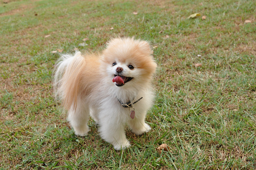

In [8]:
#@ Checking one of them
img = Image.open(path/'images/pomeranian_109.jpg')
img.thumbnail((256,256))
img

In [9]:
##@ Now, extracting the name of dog breed using regex
fname = (path/'images').ls()[0]
print("Without regex fname: ",fname)
#@ applying the regex
print("Now after regex, we get:")
re.findall(r"(.+)_\d+.jpg$", fname.name)

Without regex fname:  /root/.fastai/data/oxford-iiit-pet/images/samoyed_34.jpg
Now after regex, we get:


['samoyed']

<details>
  <summary>
    <b>
      Breakdown of the regex code
    </b>
  </summary>
  <ul>
    <li>
      <code>re.findall</code> function searches for all occurrences of the pattern in a string and returns them as a list.
    </li>
    <li>
      <code>r"(.+)_\d+.jpg$</code> is the expression that is being searched. Breaking this part even further:
      <ul>
        <li>
          <code>(.+)</code>: This captures one or more of any character (except newline) and stores it in a group.
        </li>
        <li>
          <code>_</code>: This matches the underscore character.
        </li>
        <li>
          <code>\d+</code>: This matches one or more digits
        </li>
        <li>
          <code>.jpg</code>: This matches the literal string ".jpg".
        </li>
        <li>
          <code>$</code>: This asserts the position at the end of the string.
        </li>
      </ul>
    </li>
    <li>
      <code>fname.name</code>: This is the string being searched, which is presumably the name of the file
    </li>
  </ul>
So, this code finds all the file names that match the pattern <code>something_digits.jpg</code> and captures the "something" part. For exmaple: if <code>fname.name</code> is <code>"image_123.jpg"</code>, the result would be <code>["image"]</code>.
</details>

In [10]:
#@ Testing further more with regex:
re.findall(r"(.+)", fname.name)           ## Captures the entire string in fname.name

['samoyed_34.jpg']

In [11]:
re.findall(r"(.+)_", fname.name)        ## Captures any sequence of characters until it encounters an underscore

['samoyed']

In [12]:
re.findall(r"(.+)\d+", fname.name)     ## This is termed as greedy matching.

['samoyed_3']

In [13]:
re.findall(r"(.+_\d+)", fname.name)       ## Since all of them are inside the parenthesis, it starts matching every characters, _ and digits are displayed

['samoyed_34']

**Greedy Matching**

---
The ```(.+)``` part in the regex code included above is the greedy matcher. Meaning it tries to match as much as possible while still allowing for the ```\d+``` part to match.

1. Why it stopped at ```pomeranian_10```?
    - The greedy matcher ```(.+)``` tries to match as much as possible while still allowing for the ```\d+``` part to match. It stops at ```pomeranian_10``` because it matches the entire string up to the last underscore before. It's more like leaving at least one digit to spare so that it satisfies the condition.

There is still a lot more to regex, but this much of regex would basically get the job done.

## Initializing datablock and dataloaders

Now that we have confirmed the regular expression, we can apply it to label the dataset using ```RegexLabeller``` within fastai's DataBlock API.

In [14]:
##@ Initializing datablock:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),                        # Initializing DataBlock.
                 get_items=get_image_files,                                 # Getting Image Files.
                 splitter=RandomSplitter(seed=42),                          # Getting Random Splitting of Dataset.
                 get_y=using_attr(RegexLabeller(r"(.+)_\d+.jpg$"),"name"),  # Getting Labels.
                 item_tfms=Resize(460),                                     # Resizing Images.
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))       # Batch Augmentation.

##@ Initializing dataloaders:
dls = pets.dataloaders(path/"images")

**The purpose of ```RegexLabeller```:**

---
Using ```RegexLabeller``` automates label extraction, making it easy to generalize across many files without manual naming.

### Data Augmentation and Presizing in fastai

#### DataBlock Augmentation Configuration

- ```item_tfms``` and ```batch_tfms``` are the main augmentation parameters in DataBlock.
  - ```item_tfms=Resize(460)``` resizes each image to a large size (460px) before batch augmentation.
  - ```batch_tfms=aug_transforms(size=224, min_scale=0.75)``` applies random resizing and other transformations at the batch level on the GPU.

#### Presizing Strategy

- **Purpose:** Presizing ensures consistent image dimensions and minimizes computational load by combining transformations.
    - **Step 1:** Resize images to a large size (e.g., 460px), maintaining enough margin for further augmentation without introducing empty zones.
    - **Step 2:** Apply all augmentations (e.g., random crop, resize to final model size) in one GPU operation, reducing lossy transformations and maintaining image quality.

#### Common Presizing Challenges

- Direct resizing can cause quality loss in rotated or zoomed images due to repeated interpolation.
- Fastai’s presizing combines augmentation and resizing into a single operation, applied only once, which preserves more of the original data quality.

### Checking and Debugging the DataBlock

#### Inspecting Data with ```show_batch()```

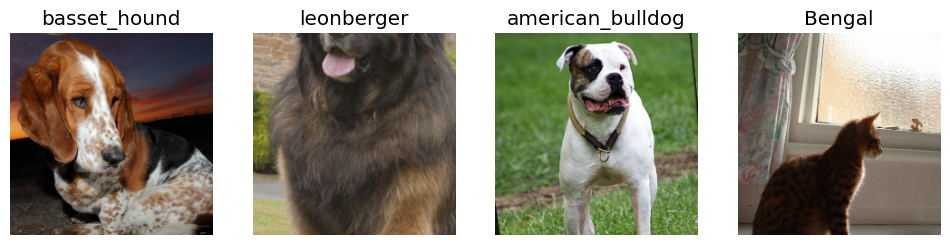

In [25]:
dls.show_batch(nrows=1, ncols=4)

#### Debugging DataBlock Construction with ```summary()```

- Use ```summary()``` to diagnose errors in the DataBlock pipeline. It will simulate the data pipeline and report on each step.

In [29]:
##@ Checking and debugging the datablock:
pets1 = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_items=get_image_files,
                  splitter=RandomSplitter(seed=42),
                  get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                  item_tfms= Resize(460)) #Adding resize to ensure consistent large dimensions


pets1.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_24.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=334x500
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_24.jpg
    applying partial gives
      Maine_Coon
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(6)

Final sample: (PILImage mode=RGB size=334x500, TensorCategory(6))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: 

### Training a Simple Model for Baseline Performance

#### Setting up a Simple Model

- Start with a simple model to gauge data suitability and establish a baseline.
- In fastai, use ```cnn_learner``` with ResNet34 and error rate as the evaluation metric:

In [30]:
##@ Training the model:
learn= cnn_learner(dls, resnet34, metrics= error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.520388,0.388951,0.123816,01:18


epoch,train_loss,valid_loss,error_rate,time
0,0.467354,0.357000,0.108254,01:17
1,0.311906,0.259667,0.074425,01:17


<details>
<summary>
<b>Purpose of Early Testing</b></summary>

Early testing reveals if the data can train a model effectively, avoiding over-complicated preprocessing for straightforward problems.

</details>

## Tomorrow: Cross Entropy Loss


Page number: 218